In [1]:
%pylab inline
import pandas as pd
import tqdm
import gensim  
from scipy import sparse
from sklearn.feature_extraction import text

Populating the interactive namespace from numpy and matplotlib


In [2]:
train_data =  pd.read_csv("kaggle_data/train_data.csv.gz", compression="gzip", encoding="utf8")

In [3]:
target = pd.read_csv("kaggle_data/train_target.csv")

#### putting together different comments of the same author

In [4]:
def extract_text(group):
    group_text = group['body'].values
    return " ".join(group_text)

#es:
extract_text(train_data[train_data.author=='RedThunder90'])

'I still prefer to buy foods either grown locally or where animals are treated better, but this definitely has me looking at organic food differently.'

In [5]:
text_dict = {}

for author, group in train_data.groupby('author'):
    text_dict[author] = extract_text(group)

In [6]:
author_text = [text_dict[author] for author in target.author]
len(author_text)

5000

#### faccio lo stesso per il test set

In [7]:
test_data = pd.read_csv("kaggle_data/test_data.csv.gz", compression="gzip", encoding="utf8")

In [8]:
test_data.body = test_data['body'].apply(str)

In [9]:
text_test_dict = {}

for author, group in test_data.groupby('author'):
    text_test_dict[author] = extract_text(group)

In [10]:
author_test_text = [text_test_dict[author] for author in test_data.author.unique()]
len(author_test_text)

15000

#### metto insieme tutti i dati che ho: train + test

In [11]:
author_total_text = author_text + author_test_text
len(author_total_text)

20000

#### vettorizzo tutti questi commenti

In [19]:
vectorizer = text.CountVectorizer(max_df=0.90, min_df= 3,
                                  stop_words= 'english' , ngram_range = (1,2), max_features=20000)

counts = vectorizer.fit_transform(author_total_text)
tfidf = text.TfidfTransformer().fit_transform(counts)

In [20]:
tfidf

<20000x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 8783113 stored elements in Compressed Sparse Row format>

#### Dataset

In [21]:
X_train = tfidf.toarray()

In [22]:
y = np.array(list(map(np.array, target.gender)))

#### split dataset in training set + validation set

In [23]:
from sklearn.model_selection import train_test_split

SEED = 2000
x_train , x_validation, y_train , y_validation = train_test_split(X_train[:5000], y, test_size = 0.2, 
                                                                 random_state = SEED)

#### MLP per classificare i vettori

In [24]:
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier

mlpClf = MLPClassifier(solver = 'adam', activation= 'relu' ,alpha = 0.015, verbose = True, early_stopping = True,
                         learning_rate = 'invscaling', max_iter = 400)


#kf = KFold(n_splits = 10)

mlpClf.fit(x_train, y_train)

"""
for train_indices, test_indices in kf.split(x_train):
    mlpClf.fit(x_train[train_indices], y_train[train_indices])
    print(mlpClf.score(x_train[test_indices], y_train[test_indices]))

"""

Iteration 1, loss = 0.66885757
Validation score: 0.725000
Iteration 2, loss = 0.57811710
Validation score: 0.735000
Iteration 3, loss = 0.51596220
Validation score: 0.772500
Iteration 4, loss = 0.44890502
Validation score: 0.797500
Iteration 5, loss = 0.38384141
Validation score: 0.827500
Iteration 6, loss = 0.32586886
Validation score: 0.835000
Iteration 7, loss = 0.27650182
Validation score: 0.835000
Iteration 8, loss = 0.23611483
Validation score: 0.837500
Iteration 9, loss = 0.20529162
Validation score: 0.842500
Iteration 10, loss = 0.18194481
Validation score: 0.835000
Iteration 11, loss = 0.16471645
Validation score: 0.820000
Iteration 12, loss = 0.15114074
Validation score: 0.820000
Validation score did not improve more than tol=0.000100 for two consecutive epochs. Stopping.


'\nfor train_indices, test_indices in kf.split(x_train):\n    mlpClf.fit(x_train[train_indices], y_train[train_indices])\n    print(mlpClf.score(x_train[test_indices], y_train[test_indices]))\n\n'

In [25]:
mlpClf.score(x_validation, y_validation)

0.838

In [26]:
y_score = mlpClf.predict_proba(x_validation)[:,1]

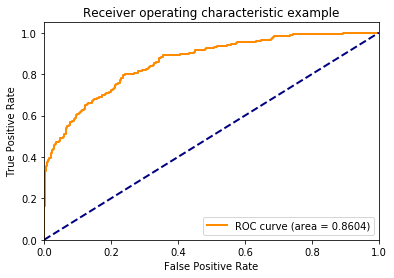

In [27]:
# Roc Curve for validation data 
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_validation, y_score)
roc_auc = auc(fpr, tpr) 


plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.4f)'% roc_auc )


plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [28]:
scoreTfIdf = pd.DataFrame({"y_validation":y_validation, "TfIdfGender":y_score})

In [31]:
scoreTfIdf.head()

,y_validation,TfIdfGender
0,0,0.083454
1,1,0.538019
2,0,0.030947
3,0,0.010865
4,0,0.561025


In [29]:
scoreTfIdf.to_csv('scoreTfIdfvalidation.csv')

### Test Data

In [32]:
y_tfidf =  mlpClf.predict_proba(X_train[5000:])[:,1]

In [33]:
solutionTfIdf = pd.DataFrame({"author":test_data.author.unique(), "ProbTfIdf":y_tfidf})

In [35]:
solutionTfIdf.to_csv('SolutionTfIdf.csv')